In [86]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
%matplotlib inline

import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

In [109]:
clothes_train = ['2015.xlsx', '2016.xlsx', '2017.xlsx' ]
clothes_test = ['Январь-февраль 2018.xls', 'Март 2018.xls']

%%time

db_train = pd.DataFrame()
for file in clothes_train:
    db_train = db_train.append(pd.read_excel('./clothes/' + file, header=2), ignore_index=True)
    
db_test = pd.DataFrame()
for file in clothes_test:
    db_test = db_test.append(pd.read_excel('./clothes/' + file, header=2), ignore_index=True)

In [120]:
def data_processing(data):
    
    names = {
        'Номер' : 'Number',
        'Дата' : 'Date',
        'Магазин' : 'Shop',
        'Артикул' : 'Vendor_code',
        'ЦветРазмер' : 'ColorSize',
        'Штрихкод' : 'Barcode',
        'Количество' : 'Quantity',
        'Сумма' : 'Amount',
        'Сезон' : 'Season',
    }
    
    data.rename(names, axis=1, inplace=True)
    
#     data.drop('НДС', axis=1, inplace=True)
#     data.drop('Number', axis=1, inplace=True)
    data = data[~data[['Amount', 'Quantity']].isnull().any(axis=1)]
    data = data[~data['Vendor_code'].isnull()]
    data['Barcode'] = data['Barcode'].fillna('0')
    data['ColorSize'] = data['ColorSize'].fillna('None, None')
    data['Season'] = data['Season'].fillna('None')

    data['Date'] = data['Date'].apply(lambda x: pd.to_datetime(x).date())
    data['Year_Month'] = data['Date'].apply(lambda date: str(date.year) + '_'+ str(date.month))
    data['Color'] = data['ColorSize'].apply(lambda x: x.split(',')[0])
    data['Size'] = data['ColorSize'].apply(lambda x: x.split(',')[-1].strip())
    data['Price'] = data['Amount'].abs() / data['Quantity'].abs()
    
    groups = data[data['Quantity'] > 0].groupby(['Shop', 'Vendor_code', 'Season', 'Color', 'Size', 'Year_Month'])
    groups = groups[['Price', 'Quantity']].agg({'Price':np.mean, 'Quantity':np.sum}).reset_index()
    
    return groups

def encoding(data):
    
    encoders = {
        'Shop' : LabelEncoder(),
        'Vendor_code' : LabelEncoder(),
        'Season' : LabelEncoder(),
        'Color' : LabelEncoder(),
        'Size' : LabelEncoder(),
        'Year_Month' : LabelEncoder()
    }

    for col in encoders.keys():
        data[col] = encoders[col].fit_transform(data[col])
    
    return data
    

In [111]:
db_train.head()

,Номер,Дата,Магазин,Артикул,ЦветРазмер,Штрихкод,Количество,Сумма,НДС,Сезон
0,0РMD-000001,01.01.2015 16:24:48,M_DYBENKO,526160A,"6510, 092",NaN,-1.0,-1799.0,-163.55,AW14
1,0РRM-000001,01.01.2015 17:15:33,M_KHIMKI,523076,"2714, 134",6.42002e+12,-1.0,-6499.0,-590.82,AW14
2,0РRM-000001,01.01.2015 17:15:33,M_KHIMKI,527170,"9990, 007",NaN,-1.0,-1259.3,-192.10,AW14
3,0РMD-000001,01.01.2015 21:59:33,M_DYBENKO,528324,"2710, 046",NaN,1.0,1499.0,136.27,AW14
4,0РMD-000001,01.01.2015 21:59:33,M_DYBENKO,516140,"3922, 068",NaN,1.0,1999.0,181.73,AW14


In [112]:
db_test.head()

,Номер,Дата,Магазин,Артикул,ЦветРазмер,Штрихкод,Количество,Сумма,НДС,Сезон
0,0РRM-000001,01.01.2018 15:48:36,M_KHIMKI,520208,"6989, 110",6.416135e+12,-1,-5999.0,-545.36,AW17
1,0Р0V-000001,01.01.2018 17:57:53,VNUKOVO,518379,"2320, 036",6.416135e+12,-1,-1189.0,-108.09,AW16
2,0РPU-000001,01.01.2018 21:01:12,PULKOVO,720710,"8313, 122",6.416135e+12,1,4199.0,381.73,AW17
3,0РPU-000001,01.01.2018 21:01:12,PULKOVO,728724,"6520, 004",6.416135e+12,1,629.0,95.95,AW17
4,0РPU-000001,01.01.2018 21:01:12,PULKOVO,723713,"6961, 134",6.416135e+12,1,4199.0,381.73,AW17


In [121]:
db_train.head()

,Date,Shop,Vendor_code,ColorSize,Barcode,Quantity,Amount,Season
0,01.01.2015 16:24:48,M_DYBENKO,526160A,"6510, 092",NaN,-1.0,-1799.0,AW14
1,01.01.2015 17:15:33,M_KHIMKI,523076,"2714, 134",6.42002e+12,-1.0,-6499.0,AW14
2,01.01.2015 17:15:33,M_KHIMKI,527170,"9990, 007",NaN,-1.0,-1259.3,AW14
3,01.01.2015 21:59:33,M_DYBENKO,528324,"2710, 046",NaN,1.0,1499.0,AW14
4,01.01.2015 21:59:33,M_DYBENKO,516140,"3922, 068",NaN,1.0,1999.0,AW14


In [122]:
data_train = data_processing(db_train)
data_train

,Shop,Vendor_code,Season,Color,Size,Year_Month,Price,Quantity
0,CDM,100001,AW16,XXXX,000,2016_1,98.505000,5.0
1,CDM,100001,AW16,XXXX,000,2016_10,99.000000,33.0
2,CDM,100001,AW16,XXXX,000,2016_11,99.000000,14.0
3,CDM,100001,AW16,XXXX,000,2016_12,99.000000,22.0
4,CDM,100001,AW16,XXXX,000,2016_2,99.000000,7.0
5,CDM,100001,AW16,XXXX,000,2016_3,99.000000,6.0
6,CDM,100001,AW16,XXXX,000,2016_4,99.000000,3.0
7,CDM,100001,AW16,XXXX,000,2016_6,99.000000,2.0
8,CDM,100001,AW16,XXXX,000,2016_8,99.000000,1.0
9,CDM,100001,AW16,XXXX,000,2016_9,98.917500,17.0


In [123]:
data_train = encoding(data_train)
data_train

,Shop,Vendor_code,Season,Color,Size,Year_Month,Price,Quantity
0,0,0,5,1219,1,12,98.505000,5.0
1,0,0,5,1219,1,13,99.000000,33.0
2,0,0,5,1219,1,14,99.000000,14.0
3,0,0,5,1219,1,15,99.000000,22.0
4,0,0,5,1219,1,16,99.000000,7.0
5,0,0,5,1219,1,17,99.000000,6.0
6,0,0,5,1219,1,18,99.000000,3.0
7,0,0,5,1219,1,20,99.000000,2.0
8,0,0,5,1219,1,22,99.000000,1.0
9,0,0,5,1219,1,23,98.917500,17.0


In [124]:
data_test = encoding(data_processing(db_test))
data_test

,Shop,Vendor_code,Season,Color,Size,Year_Month,Price,Quantity
0,0,0,3,441,0,0,49.960,4
1,0,0,3,441,0,1,99.000,1
2,0,0,3,441,0,2,99.000,5
3,0,0,3,441,0,4,98.505,4
4,0,33,4,91,43,0,3479.000,1
5,0,33,4,91,47,8,4059.000,1
6,0,33,4,282,42,4,2899.500,1
7,0,33,4,282,43,4,3479.000,1
8,0,33,4,282,44,4,5799.000,1
9,0,33,4,282,47,8,4059.000,1


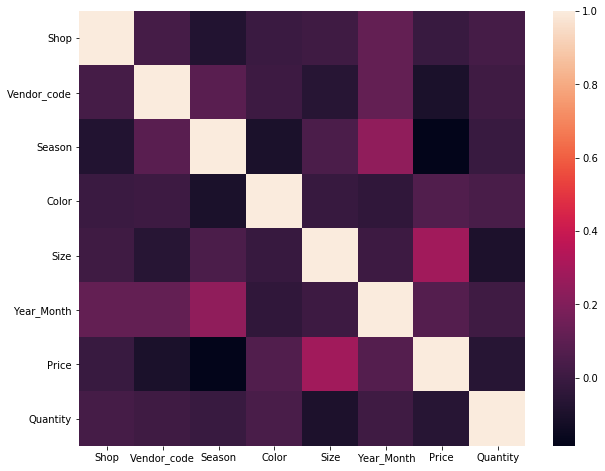

In [131]:
_, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data_train.corr(), ax=ax);

# bad try :c

In [81]:
y = shops_group['Quantity']
shops_group.drop('Quantity', axis=1, inplace=True)

In [82]:
X_train, X_test, y_train, y_test = train_test_split(shops_group, y, test_size=0.3,
                                                    random_state=17)

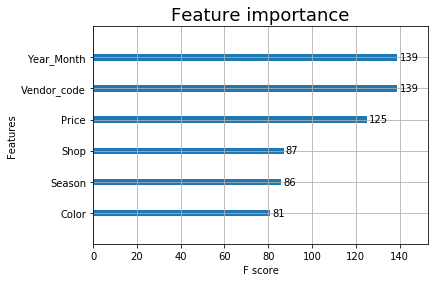

In [83]:
xgb_model = XGBRegressor(n_jobs=-1, random_state=17).fit(X_train, y_train)

xgb.plot_importance(xgb_model);

In [85]:
xgb_model.score(X_train, y_train)

0.280389527869195

# TRY NOMBER 2, ФИГХТ!

In [132]:
X_train, X_test = data_train.drop('Quantity', axis=1), data_test.drop('Quantity', axis=1)
y_train, y_test = data_train['Quantity'], data_test['Quantity']

In [133]:
np.mean(cross_val_score(XGBRegressor(n_jobs=-1, random_state=17), X_train, y_train,
                        cv=4, n_jobs=-1, verbose=2))

[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total=  17.5s
[CV] ................................................. , total=  17.4s
[CV] ................................................. , total=  17.5s
[CV] ................................................. , total=  17.8s


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   18.0s finished


0.3619297914979845

In [ ]:
grid_params = {
    'n_jobs' : [-1],
    'random_state' : [17],
    'max_depth' : [2,3,4,5],
    'n_estimators' : [100, 250, 500],
}
grid_xgb = GridSearchCV(XGBRegressor(), grid_params,
                        n_jobs=-1, cv=4, verbose=2)

# TRY RANDAM FORAST

In [ ]:
rf = RandomForestRegressor().fit(X_train, y_train)

y_pred = rf.prediction(X_test)